<a href="https://colab.research.google.com/github/bboerschinger/colabs/blob/master/2023_02_24_EquiNox_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade "jax[cpu]"
!pip install clu
!pip install equinox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import jax
import clu
from clu import deterministic_data
from clu import metrics
import equinox as eqx
import optax
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

mnist_builder = tfds.builder('mnist')
mnist_builder.download_and_prepare()

batch_size = 128
local_batch_size = batch_size // jax.device_count()
print(f'Global batch_size {batch_size}, local batch_size {local_batch_size}')

def mnist_preproc_fn(mnist_example):
  # <float>[28, 28, 1]
  image = mnist_example['image']
  # <float>[28*28]
  image = tf.reshape(image, shape=(-1,))
  return {
      'image': image,
      'label': mnist_example['label'],
  }

train_ds = deterministic_data.create_dataset(
    dataset_builder=mnist_builder,
    split=tfds.split_for_jax_process('train'),
    shuffle_buffer_size=100,
    batch_dims=[jax.local_device_count(), batch_size // jax.device_count()],
    num_epochs=1,
    preprocess_fn=mnist_preproc_fn,
    shuffle=True,
    rng=jax.random.PRNGKey(42))

test_ds = deterministic_data.create_dataset(
    dataset_builder=mnist_builder,
    split=tfds.split_for_jax_process('test'),
    batch_dims=[jax.local_device_count(), local_batch_size],
    num_epochs=1,
    preprocess_fn=mnist_preproc_fn,
    shuffle=False)

Global batch_size 128, local batch_size 128


In [4]:
class DenseLayer(eqx.Module):
    weight: jax.numpy.ndarray
    bias: jax.numpy.ndarray
    activation = lambda x: x

    def __init__(self, in_size, out_size, key):
        wkey, bkey = jax.random.split(key)
        self.weight = jax.random.normal(wkey, (in_size, out_size))
        self.bias = jax.random.normal(bkey, (out_size,))

    def __call__(self, X):
        return X @ self.weight + self.bias

# Create your model/optimizer on the "host".
in_size, out_size = 28 * 28, 10
model = DenseLayer(in_size=in_size, out_size=out_size, key=jax.random.PRNGKey(42))
optim = optax.adam(1.0)
opt_state = optim.init(model)

# Make sure to replicate them to the device(s).
model = jax.device_put_replicated(model, devices=jax.local_devices())
opt_state = jax.device_put_replicated(opt_state, devices=jax.local_devices())

def unreplicate(tree):
  """Returns a single instance of a replicated array."""
  return jax.tree_util.tree_map(lambda x: x[0], tree)

In [5]:
@jax.value_and_grad
def loss_and_val_grad(model, batch):
  # <float>[batch_size, 10]
  logits = model(batch['image'])
  # <float>[batch_size, 10]
  probs = jax.nn.log_softmax(logits, axis=-1)
  # <float>[batch_size, 10]
  y_one_hot = jax.nn.one_hot(batch['label'], num_classes=10)
  return -jax.numpy.mean(probs * y_one_hot)  

def train_step(model, batch, opt_state):
  # Forward-backward.
  loss, grads = loss_and_val_grad(model, batch)
  # Optimizer providing the weight updates and its new state.
  updates, opt_state = optim.update(grads, opt_state)
  # Applying the weight updates.
  model = eqx.apply_updates(model, updates)
  return loss, model, opt_state

def full_eval(model, eval_ds):
  def eval_step(model, batch):
    # <float>[batch_size, 10]
    logits = model(batch['image'])
    return metrics.Collection.create(
        accuracy=metrics.Accuracy
    ).gather_from_model_output(logits=logits, labels=batch['label'])
  
  eval_metrics = None
  for batch in eval_ds:
    batch = jax.tree_map(jax.numpy.asarray, batch)
    metrics_update = jax.pmap(eval_step, axis_name='batch')(model, batch)
    eval_metrics = (metrics_update if eval_metrics is None else 
                                      eval_metrics.merge(metrics_update))

  return eval_metrics.unreplicate().compute()

def visualize_weights(model):
  local_model = unreplicate(model)
  reshaped_weights = jax.numpy.reshape(local_model.weight, (28, 28, 10))

  fig, axs = plt.subplots(1, 10, figsize=(20, 20))

  for ax, digit in zip(axs, range(0, 10)): 
    ax.imshow(reshaped_weights[:, :, digit])
    ax.set_title(str(digit))
    ax.set_xticks([])
    ax.set_yticks([])

Before training (randomly initialized) on test:  {'accuracy': Array(0.0673077, dtype=float32)}
After training on test: {'accuracy': Array(0.8678886, dtype=float32)}


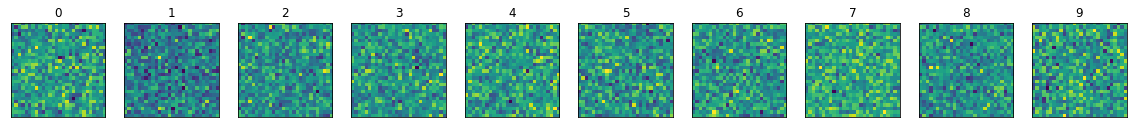

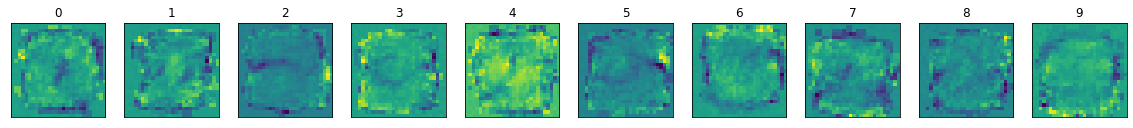

In [6]:
print(f'Before training (randomly initialized) on test:  {full_eval(model, test_ds)}')
visualize_weights(model)

for batch in train_ds:
  # TF-to-JAX boundary - numpy all the tensors.
  batch = jax.tree_map(jax.numpy.asarray, batch)
  loss, model, opt_state = jax.pmap(train_step, axis_name='batch')(model, batch, opt_state)

print(f'After training on test: {full_eval(model, test_ds)}')
visualize_weights(model)